In [1]:
import numpy as np
import pandas as pd
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import binom
from sklearn.metrics import confusion_matrix

import mle
import flmp
from libfunc import to_table_body

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# get paths to data files
file_paths = glob("./data/*.txt")

# load all data into a single array
data = np.array([np.loadtxt(fname) for fname in file_paths])
N, M, K = data.shape

# define number of samples for each subject
n_samples = 24 

# number of samples for simulated data
N_SAMPLES = 100

In [3]:
train_results = np.zeros((2, N, M, K))
test_results = np.zeros((2, N, M, K))
probs = np.zeros((2, N, M, K))
for n in range(N):
    subject_data = data[n]
    for m in range(M):
        for k in range(K):
            train_results[0, n, m, k], tA, tV = flmp.fit(np.ones(K*2), subject_data, 24, K, leave_out_idx=(m, k))
            p_A, p_V, p_AV = flmp.compute_probs(tA, tV)
            p = np.vstack([p_A.T, p_V.T, p_AV])
            test_results[0, n, m, k] = -binom.logpmf(subject_data[m, k], 24, p[m, k])
            probs[0, n, m, k] = p[m, k]
            
            train_results[1, n, m, k], c_A, c_V, std_A, std_V = mle.fit(np.ones(4), subject_data, 24, leave_out_idx=(m, k))
            p_A, p_V, p_AV = mle.compute_probs(c_A, c_V, np.exp(std_A), np.exp(std_V))
            p = np.vstack([p_A.T, p_V.T, p_AV])
            test_results[1, n, m, k] = -binom.logpmf(subject_data[m, k], 24, p[m, k])
            probs[1, n, m, k] = p[m, k]

train_results = train_results.reshape(2, N, -1)
test_results = test_results.reshape(2, N, -1).sum(axis=2)
probs = probs.reshape(2, N, -1)

In [4]:
flmp_df = pd.DataFrame(train_results[0].T, columns=[f"Subject {i+1}" for i in range(N)])
mle_df = pd.DataFrame(train_results[1].T, columns=[f"Subject {i+1}" for i in range(N)])

df = pd.concat([flmp_df, mle_df], join='outer', axis=1, keys=["FLMP", "MLE"]).round(2)
df.index = df.index + 1
df.to_latex("cv_training_errors.txt")
df

FLMP                                               MLE            \
   Subject 1 Subject 2 Subject 3 Subject 4 Subject 5 Subject 1 Subject 2   
1      46.43     31.87     51.60     46.50     42.71     72.67     52.39   
2      46.06     31.53     49.47     45.76     41.57     71.52     53.42   
3      45.78     30.99     51.49     45.48     39.01     68.27     53.18   
4      44.76     30.21     51.38     45.32     41.24     65.63     52.13   
5      46.24     32.78     53.27     46.66     42.77     71.99     54.96   
6      45.95     32.86     51.10     44.67     41.36     67.71     53.81   
7      45.60     30.69     51.25     45.18     40.97     69.66     47.98   
8      45.95     31.94     51.83     45.09     37.56     70.14     53.98   
9      46.65     32.84     50.98     44.23     41.44     72.62     55.07   
10     46.80     32.92     52.23     44.80     41.58     72.80     55.08   
11     47.30     32.99     51.62     46.88     42.81     72.64     55.04   
12     47.22     32.97     52.78     44.25     42.79     71.69     54.68   
13     47.06     32.90     51.09     42.76     41.17     67.90     52.66   
14     45.03     31.08     51.56     45.04     40.79     70.98     49.95   
15     45.35     30.88     52.13     45.37     41.74     69.50     49.39   
16     44.40     30.46     51.65     46.79     40.67     68.51     52.60   
17     43.08     30.90     51.20     46.57     41.77     69.36     52.21   
18     45.39     29.94     50.69     45.89     40.68     69.69     53.17   
19     40.54     26.75     50.64     44.93     41.81     70.62     52.98   
20     43.92     32.91     53.29     45.88     42.78     71.53     53.64   
21     45.48     30.78     51.45     46.61     42.16     68.63     53.00   
22     45.48     30.92     51.06     46.06     41.49     69.75     53.28   
23     45.71     31.46     51.46     45.64     40.25     71.09     52.75   
24     47.23     32.91     51.98     45.31     40.99     70.96     54.69   
25     47.29     32.98     53.36     46.57     42.81     72.49     55.04   
26     45.50     31.32     51.07     45.87     41.04     70.48     52.80   
27     44.87     32.00     47.79     45.20     41.23     70.77     54.02   
28     45.92     32.78     51.81     45.12     41.00     71.47     54.99   
29     47.28     32.98     53.21     42.71     40.37     72.53     55.07   
30     47.31     32.99     53.37     46.84     42.81     72.77     55.08   
31     45.29     30.87     50.06     44.69     41.17     67.52     45.61   
32     45.58     32.52     50.95     45.12     41.08     67.45     55.06   
33     45.80     32.89     51.95     45.03     41.27     71.06     55.08   
34     47.30     32.98     53.25     45.36     42.75     72.78     55.08   
35     47.32     32.99     53.37     46.88     42.81     72.80     55.08   

                                  
   Subject 3 Subject 4 Subject 5  
1      68.96     67.20     53.55  
2      66.07     66.57     51.96  
3      63.86     61.98     51.64  
4      66.23     63.87     49.95  
5      69.15     66.99     53.49  
6      65.80     66.36     49.55  
7      66.30     64.76     49.88  
8      67.76     65.26     48.63  
9      68.30     64.91     52.26  
10     66.96     62.45     53.53  
11     67.93     67.21     53.55  
12     67.06     64.71     53.40  
13     65.38     65.95     51.12  
14     67.61     65.39     50.44  
15     67.56     65.72     52.56  
16     66.76     67.20     48.42  
17     67.61     66.84     52.46  
18     64.83     62.41     51.28  
19     67.69     63.54     50.31  
20     68.44     66.09     53.33  
21     65.31     67.17     53.49  
22     67.58     66.11     52.28  
23     67.70     62.02     51.68  
24     68.24     64.00     52.43  
25     69.17     66.59     53.51  
26     64.71     65.11     49.82  
27     66.18     65.17     51.80  
28     67.98     63.35     51.74  
29     68.87     65.77     52.28  
30     69.37     67.02     53.54  
31     66.64     59.17     52.55  
32     67.78     64.94     50.73  
33   

In [5]:
test_results

array([[ 66.69455697, 338.13813799,  87.8587574 ,  57.38571673,
         70.46966326],
       [ 89.2967681 ,  73.01057906,  80.73466285,  79.65111495,
         64.84448411]])

In [6]:
flmp_df = pd.DataFrame(test_results[0])
mle_df = pd.DataFrame(test_results[1])

df = pd.concat([flmp_df, mle_df], join='outer', axis=1).round(2)
df.columns = ["FLMP", "MLE"]
df.index = [f"Subject {i+1}" for i in range(N)]
df.to_latex("cv_test_errors.txt")
df

,FLMP,MLE
Subject 1,66.69,89.30
Subject 2,338.14,73.01
Subject 3,87.86,80.73
Subject 4,57.39,79.65
Subject 5,70.47,64.84


In [7]:
probs = probs.reshape(2, N, -1)
data_props = data.reshape(N, -1)/24

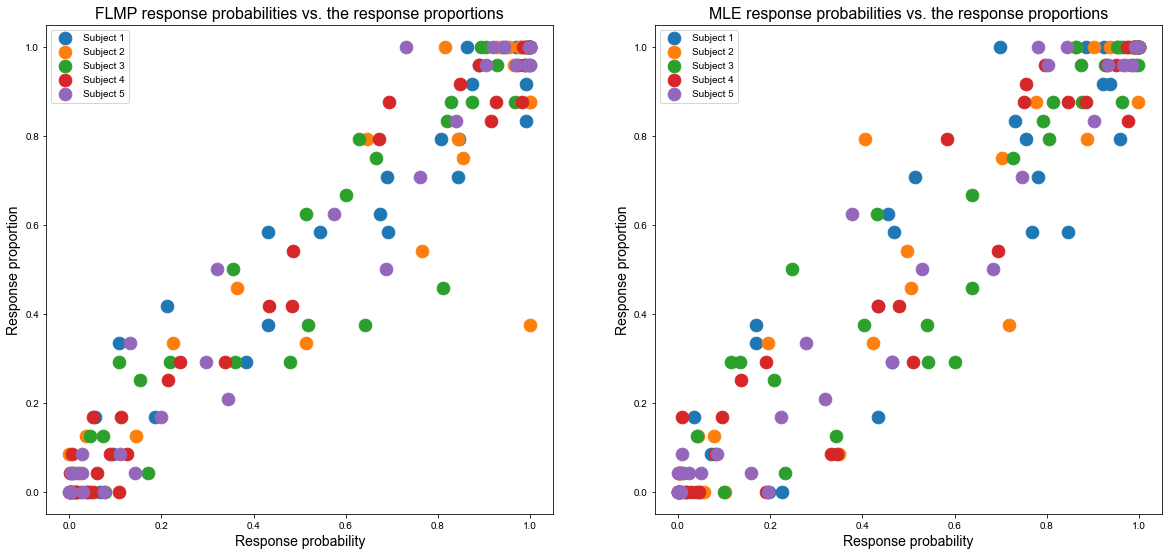

In [8]:
# define stuff to plot
x = probs[0]
y = data_props

# plot FLMP response probabilities vs. response proportions
fig = plt.figure(figsize=(20, 9))
ax1 = fig.add_subplot(121)
for idx in range(len(x)):
    ax1.scatter(x[idx], y[idx], s=160, label=f'Subject {idx+1}')
plt.legend(loc='upper left')
plt.title("FLMP response probabilities vs. the response proportions", fontsize=16)
plt.xlabel('Response probability', fontsize=14)
plt.ylabel('Response proportion', fontsize=14)
ax1.grid(False)

# define stuff to plot
x = probs[1]
y = data_props

# plot MLE response probabilities vs. response proportions
ax1 = fig.add_subplot(122)
for idx in range(len(x)):
    ax1.scatter(x[idx], y[idx], s=160, label=f'Subject {idx+1}')
plt.legend(loc='upper left')
plt.title("MLE response probabilities vs. the response proportions", fontsize=16)
plt.xlabel('Response probability', fontsize=14)
plt.ylabel('Response proportion', fontsize=14)
ax1.grid(False)
sns.set_style("whitegrid")
plt.savefig('./visualizations/cv_scatter.png', transparent=True, bbox_inches="tight")
plt.show()